In [24]:
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pickle
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/applebelle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/applebelle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
#Load data
df_title = pd.read_csv('./data/df_title.csv')
df_title = df_title.fillna(' ')

In [11]:
#Perform Train-Test-Split on the Data

X = df_title["title"]
y = df_title["target"]

X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [12]:
# Check for the best classifier between BernoulliNB, MultimodialNB, LogisticRegression, K-Nearest Neighbors, Support Vector Machines

cvec = CountVectorizer(max_features=500, stop_words="english")
tvec = TfidfVectorizer(max_features=500, stop_words="english")
hvec = HashingVectorizer(non_negative=True)
bernoulli = BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
multimodial = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

vect_models = {"CountVectorizer": cvec, "TD-IDF Vectorizer": tvec, "Hash Vectorizer":hvec}
nb_models = {"BernoulliNB": bernoulli, "MultimodialNB":multimodial}

results = {}
for a, b in vect_models.items():
    for c, d in nb_models.items():
        pipe = Pipeline([
            (a, b),
            (c, d)
            ])
        pipe.fit(X_train_title, y_train_title)
        results["{} w/ {}".format(c, a)] = pipe.score(X_test_title, y_test_title)
        pipe = Pipeline([(a, b),("estimator", LogisticRegression())])

        params_grid = [{
                'estimator':[LogisticRegression()],
                'estimator__penalty': ["l1", "l2"],
                'estimator__C': np.linspace(0.1, 1, num=10)
                },            
                {
                'estimator':[KNeighborsClassifier()],
                'estimator__n_neighbors': range(1,10)
                },
                {
                'estimator':[SVC()],
                'estimator__C': [1, 10, 100, 1000],
                'estimator__gamma': [0.001, 0.0001],
                }]
        grid = GridSearchCV(pipe,params_grid, cv=5,n_jobs=2)
        grid.fit(X_train_title, y_train_title)
        results["Alternative Classifier w/ {}".format(a)] = grid.best_estimator_.score(X_test_title, y_test_title)

/Users/applebelle/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/Users/applebelle/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/Users/applebelle/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/Users/applebelle/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This 

In [33]:
#Print the results in Pandas Dataframe
df = pd.DataFrame.from_dict(results, orient="index").sort_values(by=0, ascending=False)
df

,0
Alternative Classifier w/ Hash Vectorizer,0.951435
Alternative Classifier w/ TD-IDF Vectorizer,0.938190
Alternative Classifier w/ CountVectorizer,0.931567
BernoulliNB w/ CountVectorizer,0.929360
BernoulliNB w/ TD-IDF Vectorizer,0.929360
MultimodialNB w/ CountVectorizer,0.927152
MultimodialNB w/ TD-IDF Vectorizer,0.927152
MultimodialNB w/ Hash Vectorizer,0.905077
BernoulliNB w/ Hash Vectorizer,0.518764


In [14]:
#Check the hyperparameters of the best estimator
grid.best_params_

{'estimator': SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False), 'estimator__C': 1000, 'estimator__gamma': 0.001}

In [15]:
#Model and fit using the best estimator and vectorizer
hvec = HashingVectorizer(non_negative=True)
X_train_hvec = hvec.fit_transform(X_train_title)
X_test_hvec = hvec.transform(X_test_title)

svm_model = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
   max_iter=-1, probability=True, random_state=None, shrinking=True,
   tol=0.001, verbose=False)
svm_model.fit(X_train_hvec, y_train_title)

#Predict the results and probabilities using this best estimator
pred = svm_model.predict(X_test_hvec)
pred_proba = svm_model.predict_proba(X_test_hvec)

#Create a Pandas Dataframe to record the results
y_test_df = pd.DataFrame(y_test_title).rename(columns={"target":"true"}).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test_title).reset_index(drop=True)
actual = pd.concat([X_test_df, y_test_df], axis=1)

pred = pd.DataFrame(pred).rename(columns={0:"pred"})
pred_proba = pd.DataFrame(pred_proba).rename(columns={1:"pred_proba"})
pd.concat([actual, pred, pred_proba], axis=1)
roc_auc = pd.concat([actual, pred, pred_proba], axis=1).drop(columns=0)

#View the incorrectly predicted titles
roc_auc[roc_auc["true"] != roc_auc["pred"]]

/Users/applebelle/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/Users/applebelle/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/Users/applebelle/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


,title,true,pred,pred_proba
27,ethics office investigates whether interior de...,0,1,0.912938
39,he didnt appreciate it as much as i did,1,0,0.196187
63,us currency has some of the highest math score...,1,0,0.285566
91,in god we trust going up at south dakota publi...,0,1,0.662367
111,rand paul aide calls jon stewart a disheveled ...,0,1,0.526631
112,those hit hardest by student debt never finish...,0,1,0.816280
119,barr says police need encryption backdoors doe...,0,1,0.450087
122,house passes measure endorsing all trumpfocuse...,0,1,0.645138
125,thank laws supported by atampt and comcast for...,0,1,0.544182
149,why was the ratio of the side opposite an angl...,1,0,0.312533


In [16]:
#Create a confusion matrix

cm = confusion_matrix(roc_auc.true, roc_auc.pred)
cm_df = pd.DataFrame(cm, columns=["pred negative", "pred positive"], index=["actual negative", "actual positive"])
cm_df

,pred negative,pred positive
actual negative,200,18
actual positive,4,231


In [17]:
#Quantify the performance of the model

tn, fp, fn, tp = cm.ravel()
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)

print(f'Recall/Sensitivity: {round(sens,4)}')

print("Type I Error: ",fp)
print("Type II Error: ",fn)

Specificity: 0.9174
Recall/Sensitivity: 0.983
Type I Error:  18
Type II Error:  4


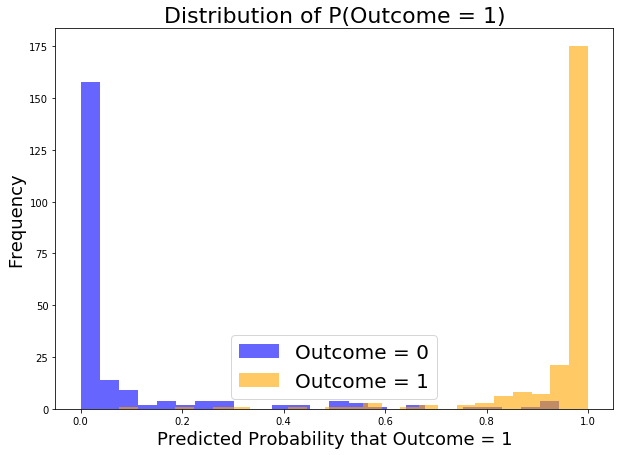

In [18]:
# Analyze the distribution of the prediction accuracy
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(roc_auc[roc_auc['true'] == 0]['pred_proba'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(roc_auc[roc_auc['true'] == 1]['pred_proba'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

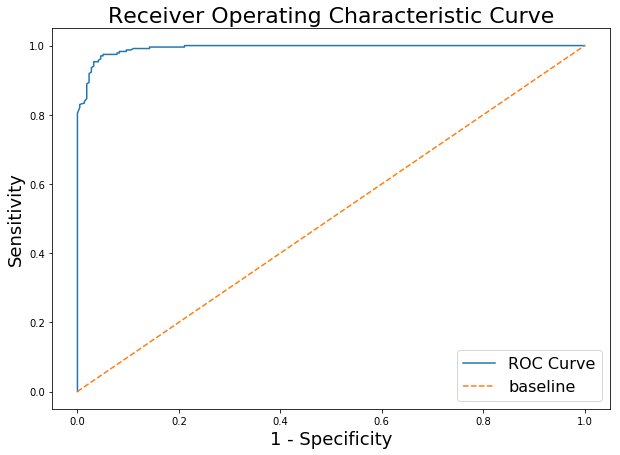

In [19]:
# Visualize the ROC Curve
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(roc_auc, true, pred_proba, threshold):
    true_positive = roc_auc[(roc_auc[true] == 1) & (roc_auc[pred_proba] >= threshold)].shape[0]
    false_negative = roc_auc[(roc_auc[true] == 1) & (roc_auc[pred_proba] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(roc_auc, true, pred_proba, threshold):
    true_negative = roc_auc[(roc_auc[true] == 0) & (roc_auc[pred_proba] <= threshold)].shape[0]
    false_positive = roc_auc[(roc_auc[true] == 0) & (roc_auc[pred_proba] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(roc_auc, 'true', 'pred_proba', prob) for prob in thresholds]
fpr_values = [FPR(roc_auc, 'true', 'pred_proba', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [26]:
#Analyze the most common words in puns thread

#Import word list from txt
with open("./data/puns_title.txt", "rb") as fp:
    puns_title = pickle.load(fp)
    
with open("./data/politics_title.txt", "rb") as fp:
    politics_title = pickle.load(fp)

#Tokenize the words
word_token = [word_tokenize(i) for i in puns_title]
word_token

#Flatten the list
flat_list = [item for sublist in word_token for item in sublist]

#Lower the character cases
flat_list = [x.lower() for x in flat_list]

#Remove stopwords
stop_words = stopwords.words('english')
flat_list = [word for word in flat_list if word not in stop_words]

#Remove special characters
flat_list = [re.sub('[^A-Za-z0-9]+', '', x) for x in flat_list]

#Count the word occurence
word_freq= (Counter(flat_list))

#Record the results in Pandas DataFrame
puns_df = pd.DataFrame.from_dict(word_freq, orient='index').reset_index()
puns_df.rename(columns={'index':'words', 0:'count'}, inplace=True)
puns_df = puns_df[puns_df.words != '']
puns_df = puns_df[puns_df.words != 's']
puns_df = puns_df[puns_df.words != 'nt']
puns_df = puns_df.sort_values(by="count", ascending=False)

Text(0.5, 1.0, "Most Common Words in Reddit's Puns Thread")

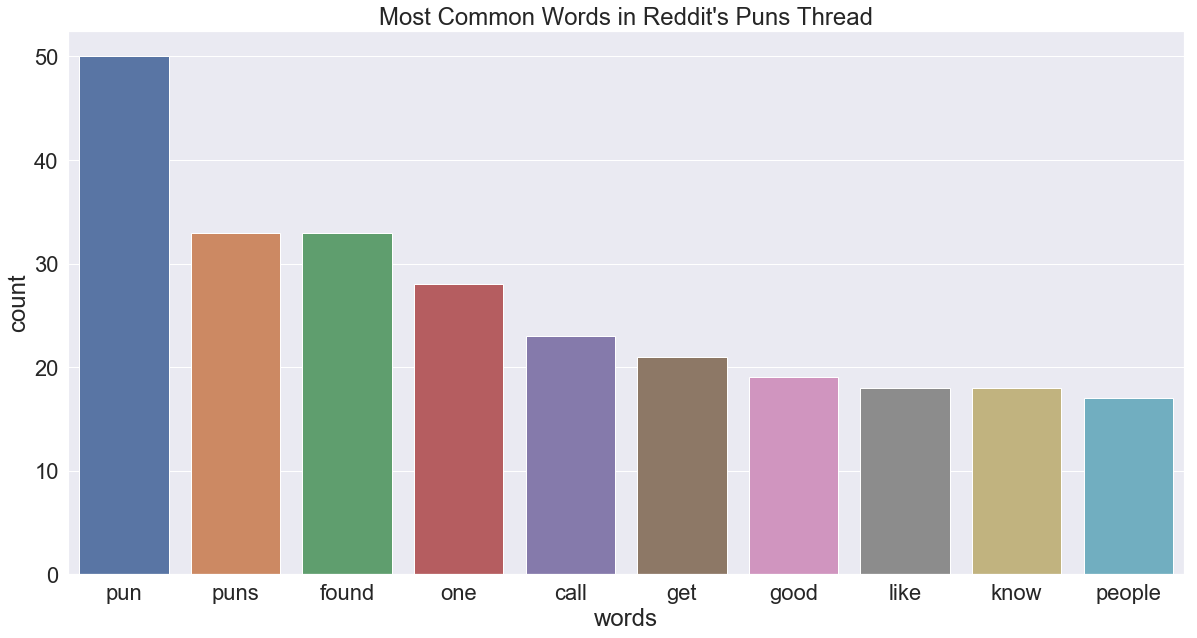

In [27]:
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="words", y="count", data=puns_df[puns_df["count"] >= 15]).set_title("Most Common Words in Reddit's Puns Thread")

In [29]:
#Analyze the most common words in politics thread

#Tokenize the words
word_token = [word_tokenize(i) for i in politics_title]
word_token

#Flatten the list
flat_list = [item for sublist in word_token for item in sublist]

#Lower the character cases
flat_list = [x.lower() for x in flat_list]

#Remove stopwords
stop_words = stopwords.words('english')
flat_list = [word for word in flat_list if word not in stop_words]

#Remove special characters
flat_list = [re.sub('[^A-Za-z0-9]+', '', x) for x in flat_list]

#Count the word occurence
word_freq= (Counter(flat_list))

#Record the results in Pandas DataFrame
politics_df = pd.DataFrame.from_dict(word_freq, orient='index').reset_index()
politics_df.rename(columns={'index':'words', 0:'count'}, inplace=True)
politics_df = politics_df[politics_df.words != '']
politics_df = politics_df[politics_df.words != 's']
politics_df = politics_df.sort_values(by="count", ascending=False)

Text(0.5, 1.0, "Most Common Words in Reddit's Politics Thread")

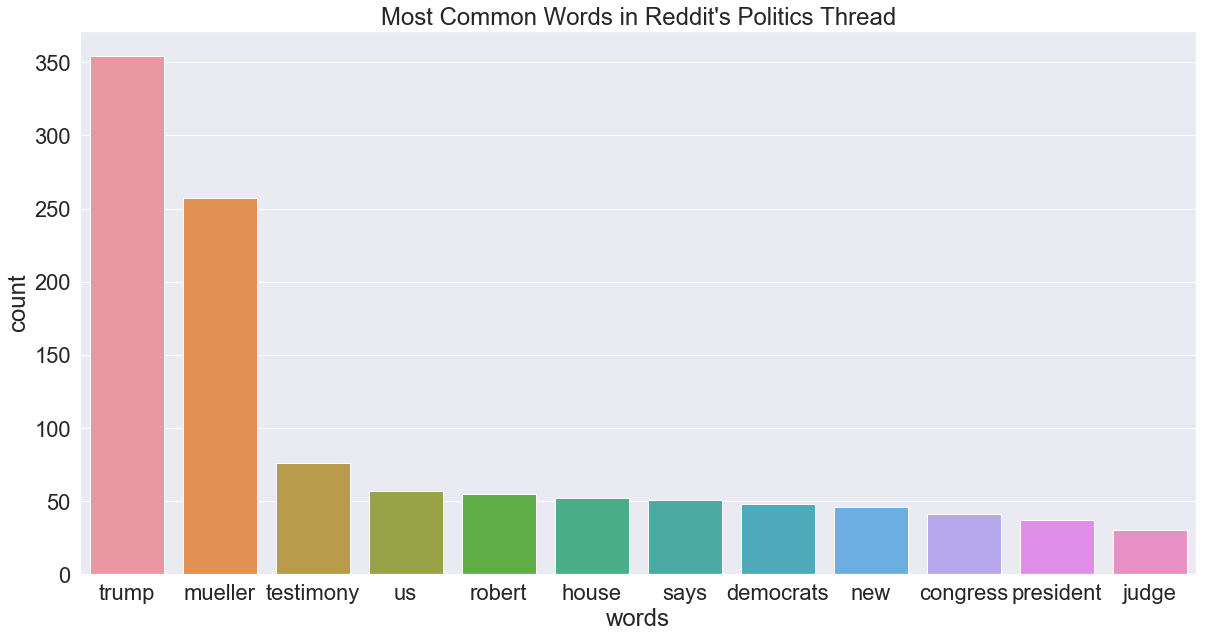

In [30]:
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="words", y="count", data=politics_df[politics_df["count"] >= 30]).set_title("Most Common Words in Reddit's Politics Thread")

In [31]:
#Analyze Sentiment

puns_sent = {}
analyzer = SentimentIntensityAnalyzer()
for sentence in puns_title:
    vs = analyzer.polarity_scores(sentence)
    puns_sent[sentence] = vs
puns_sent = pd.DataFrame.from_dict(puns_sent).transpose()
puns_sent["thread"] = "puns"

politics_sent = {}
analyzer = SentimentIntensityAnalyzer()
for sentence in politics_title:
    vs = analyzer.polarity_scores(sentence)
    politics_sent[sentence] = vs
politics_sent = pd.DataFrame.from_dict(politics_sent).transpose()
politics_sent["thread"] = "politics"

df = pd.concat([puns_sent, politics_sent])

df_melt = pd.melt(df, id_vars=['thread'], var_name="Sentiment", value_name='Score').replace({"compound":"Overall", "neg":"Negative", "neu":"Neutral", "pos":"Positive"})
#df_melt = df_melt[~(df_melt['Score'] <= 0.05)]  

Text(0.5, 1.0, "Sentiment Across Reddit's Puns and Politics Thread")

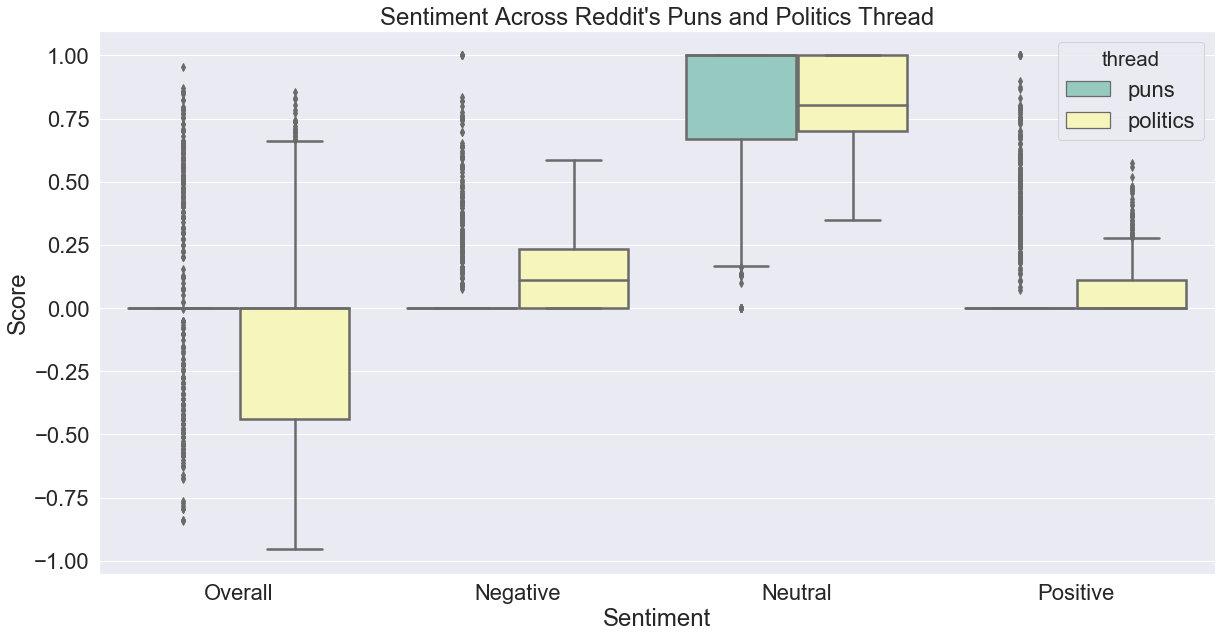

In [32]:
#Visualize the Sentiments
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x="Sentiment", y="Score", hue="thread", data=df_melt, palette="Set3", linewidth=2.5).set_title("Sentiment Across Reddit's Puns and Politics Thread")